In [1]:
# MODULE IMPORTS ----

# warning settings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data management
import pandas as pd
import numpy as np
import pickle

# Plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# Stats functionality
from statsmodels.distributions.empirical_distribution import ECDF

# HDDM
import hddm
from hddm.simulators.hddm_dataset_generators import simulator_h_c

# Single subject one day

In [2]:
yn_data = pd.read_csv('./data/data_choiceYN.csv')

In [3]:
yn_data.columns

Index(['subnum', 'day', 'week', 'stimNum', 'type', 'orientation', 'filling',
       'shape', 'valueO', 'valueF', 'valueS', 'session', 'yesChosen',
       'response', 'payoff', 'possiblePayoff', 'reference', 'inizialTime',
       'endTime', 'inizialTimeResp', 'endTimeResp', 'rt', 'startFix',
       'evtimeON', 'evtimeOFF', 'crossON', 'fmri'],
      dtype='object')

In [4]:
yn_tmp = yn_data.loc[:, ['subnum', 'day', 'type', 'rt', 'yesChosen', 'possiblePayoff', 'reference', 'session']]
yn_tmp['subj_idx'] = yn_tmp['day']
yn_tmp['response'] = yn_tmp['yesChosen'].astype('float')

In [5]:
yn_subj_day = yn_tmp[(yn_tmp['subnum'] == 601) & (yn_tmp['day'] == 1)]
yn_subj_day

,subnum,day,type,rt,yesChosen,possiblePayoff,reference,session,subj_idx,response
0,601,1,0,5.238478,1,12,0,1,1,1.0
1,601,1,0,3.269486,1,-60,0,1,1,1.0
2,601,1,0,1.878495,1,-108,0,1,1,1.0
3,601,1,0,1.165697,1,57,0,1,1,1.0
4,601,1,0,3.851911,1,-9,0,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...
795,601,1,1,0.680138,1,35,0,4,1,1.0
796,601,1,1,0.690004,1,48,0,4,1,1.0
797,601,1,0,0.553679,1,78,0,4,1,1.0
798,601,1,1,0.763399,1,17,0,4,1,1.0


## Constant bounds

Drift rate depends on stimulus type (HT vs RE) but **not** value difference yet

In [6]:
# Metadata
nmcmc = 1000
burn = 500

In [7]:
hddmnn_model_subj_day_ddm = hddm.HDDMnn(yn_subj_day,
                               model = 'ddm',
                               informative = False,
                               include = hddm.simulators.model_config['ddm']['hddm_include'],
                               p_outlier = 0.05,
                               is_group_model = False,
                               depends_on = {'v': 'type'})

Supplied model_config specifies params_std_upper for  z as  None.
Changed to 10


In [8]:
hddmnn_model_subj_day_ddm.sample(nmcmc, burn = burn)

 [-----------------100%-----------------] 1000 of 1000 complete in 41.6 sec

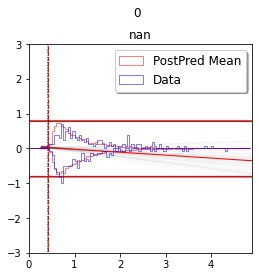

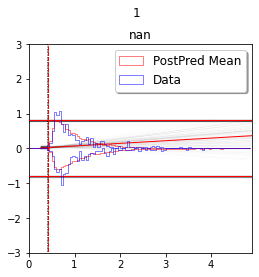

In [9]:
hddm.plotting.plot_posterior_predictive(model = hddmnn_model_subj_day_ddm,
                                        columns = 1,
                                        figsize = (4, 4),
                                        value_range = np.arange(0, 5, 0.1),
                                        plot_func = hddm.plotting._plot_func_model,
                                        parameter_recovery_mode = False,
                                        hist_bottom = 0,
                                        **{'alpha': 0.01,
                                        'ylim': 3,
                                        'add_posterior_uncertainty_model': True,
                                        'add_posterior_uncertainty_rts': False,
                                        'add_posterior_mean_rts': True,
                                        'samples': 200})
plt.show()

Parameters:   
`v(0)`: drift rate for RE    
`v(1)`: drift rate for HT   
`a`: Boundary separation  
`z`: Starting point bias  
`t`: Non-decision time  

**Note: no noise parameter**

tracename: 
v(0)
tracename: 
v(1)
tracename: 
a
tracename: 
z
tracename: 
t


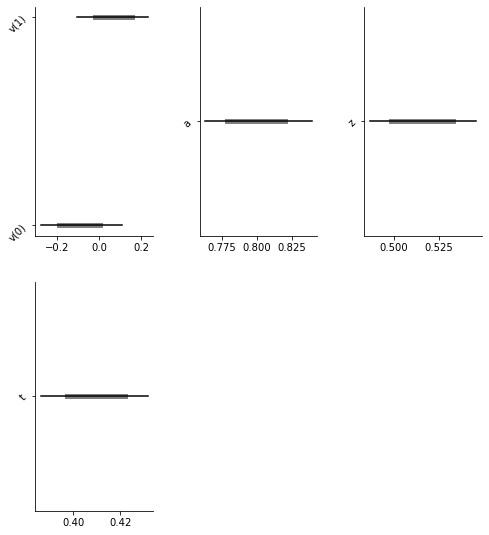

In [10]:
hddm.plotting.plot_caterpillar(hddm_model = hddmnn_model_subj_day_ddm,
                               figsize = (8, 8),
                               columns = 3)

plt.show()

What does choice and RT depend on?  
- Value difference - ??
- Reference amount - ??
- Stimulus type - depends on
- Day of visit - hierarchy over (subj_idx)
- Similarity to HT - ??

Would HDDMrl be more appropriate?

In [20]:
# data = hddm.load_csv("rlddm_data.csv")
data = pd.read_csv(os.path.join(hddm.__path__[0], 'examples', 'rlddm_data.csv'))
data

,subj_idx,response,cond,rt,trial,split_by,feedback,q_init
0,42,0.0,CD,1.255,1.0,1,0.0,0.5
1,42,1.0,EF,0.778,1.0,2,0.0,0.5
2,42,1.0,AB,0.647,1.0,0,1.0,0.5
3,42,1.0,AB,0.750,2.0,0,1.0,0.5
4,42,0.0,EF,0.772,2.0,2,1.0,0.5
...,...,...,...,...,...,...,...,...
5275,80,1.0,CD,0.680,39.0,1,1.0,0.5
5276,80,1.0,AB,0.814,39.0,0,1.0,0.5
5277,80,1.0,EF,0.693,40.0,2,0.0,0.5
5278,80,1.0,CD,1.798,40.0,1,0.0,0.5


In [24]:
data[(data['subj_idx'] == 42)]['cond'].value_counts()

AB    60
EF    60
CD    60
Name: cond, dtype: int64

In [36]:
tmp = yn_data.loc[:, ['subnum', 'day', 'type', 'rt', 'yesChosen', 'possiblePayoff', 'reference', 'stimNum' ,'session']]
yn_subj = tmp[(tmp['subnum'] == 601)]
# yn_subj = tmp[(tmp['subnum'] == 601) & (tmp['day'] == 1)]
# pandas.set_option('display.max_rows', None)
pd.DataFrame(yn_subj.stimNum.value_counts()).head(500)

,stimNum
371,440
158,440
333,440
123,440
332,440
620,440
698,440
645,440
670,440
100,440


## Collapsing bounds

In [ ]:
# Metadata
nmcmc = 1000
burn = 500

In [ ]:
hddmnn_model_subj_day_angle = hddm.HDDMnn(yn_subj_day,
                               model = 'angle',
                               informative = False,
                               include = hddm.simulators.model_config['angle']['hddm_include'],
                               p_outlier = 0.05,
                               is_group_model = False,
                               depends_on = {'v': 'type'})

In [ ]:
hddmnn_model_subj_day_angle.sample(nmcmc, burn = burn)

In [ ]:
hddm.plotting.plot_posterior_predictive(model = hddmnn_model_subj_day_angle,
                                        columns = 1,
                                        figsize = (4, 4),
                                        value_range = np.arange(0, 5, 0.1),
                                        plot_func = hddm.plotting._plot_func_model,
                                        parameter_recovery_mode = False,
                                        hist_bottom = 0,
                                        **{'alpha': 0.01,
                                        'ylim': 3,
                                        'add_posterior_uncertainty_model': True,
                                        'add_posterior_uncertainty_rts': False,
                                        'add_posterior_mean_rts': True,
                                        'samples': 200})
plt.show()

In [ ]:
hddm.plotting.plot_caterpillar(hddm_model = hddmnn_model_subj_day_angle,
                               figsize = (8, 8),
                               columns = 3)

plt.show()

# Hierarchcial - single subject all days

In [ ]:
hddmnn_model_subj = hddm.HDDMnn(yn_subj,
                               model = model,
                               informative = False,
                               include = hddm.simulators.model_config[model]['hddm_include'],
                               p_outlier = 0.05,
                               is_group_model = True,
                               depends_on = {'v': 'type'})